# Test the gyroscope dynamics with
#### -- Complete 6D model 
#### -- Simplifed 4D model
# Under the control of 
#### -- Linear controller
#### -- RL controller

## Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.integrate import solve_ivp
from math import cos,sin
import torch
import spinup

ModuleNotFoundError: No module named 'spinup'

## Frame of reference (cf Agram)

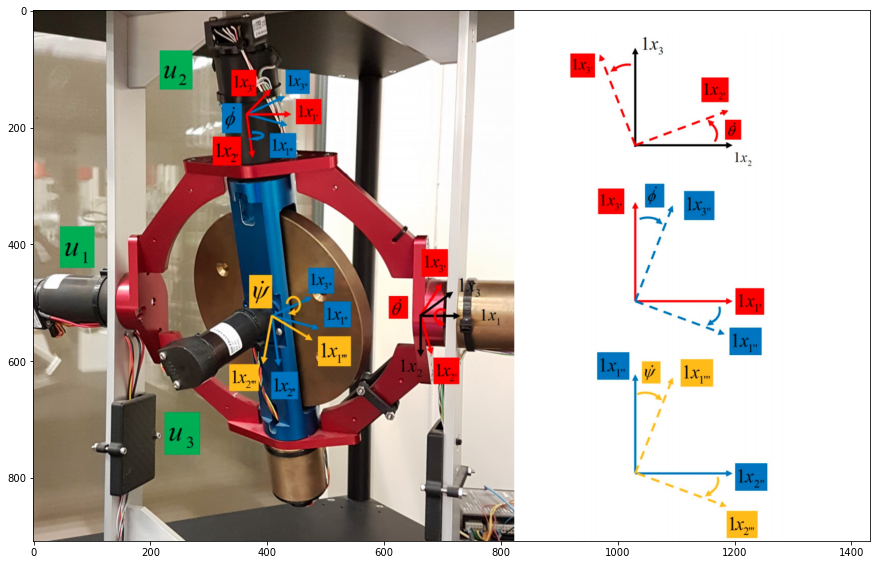

In [2]:
f = plt.subplots(figsize=(15,15))
img = mpimg.imread('AgramFrame.png')
imgplot = plt.imshow(img)

## 3D Rendering

In [3]:
# # Scene
# scene = canvas(background=color.white) 

# # Objects
# redGimbal = ring(pos=vector(0,0,0), axis=vector(0,0,1), radius=2, thickness=0.2,color=vector(0.9,0,0))
# blueGimbal1 = cylinder(pos=vector(0,0,0), axis=vector(0,2,0), radius=0.3,color=color.blue)
# blueGimbal2 = cylinder(pos=vector(0,0,0), axis=vector(0,-2,0), radius=0.3,color=color.blue)
# disk1 = cylinder(pos=vector(0,0,0), axis=vector(0,0,0.15), radius=1.3,color=color.yellow)
# disk2 = cylinder(pos=vector(0,0,0), axis=vector(0,0,-0.15), radius=1.3,color=color.yellow)
# baseR = extrusion(path=[vec(0,0,0), vec(0.7,0,0)],shape=[ shapes.circle(radius=0.5) ], pos=vec(2,0,0), color=color.black)
# baseL = extrusion(path=[vec(-0.7,0,0), vec(0,0,0)],shape=[ shapes.circle(radius=0.5) ], pos=vec(-2,0,0), color=color.black)

# t = 0
# dt = 0.01
# loops = 0
# ctime = 0
# start = clock()
# N = 200

# # 6.4/100
# for k in range(len(time)):
#     rate(N)
#     ct = clock()
#     theta = val[k][0]
#     phi = val[k][2]
#     redGimbal.axis = vector(0,-sin(theta), cos(theta))
#     blueGimbal1.axis = 2*vector(0,cos(theta), sin(theta))
#     blueGimbal2.axis = -2*vector(0,cos(theta), sin(theta))
#     disk1.axis = 0.15*vector(-sin(phi),-sin(theta)*cos(phi),cos(theta)*cos(phi))
#     disk2.axis = -0.15*vector(-sin(phi),-sin(theta)*cos(phi),cos(theta)*cos(phi))
#     ctime += clock()-ct
#     loops += 1

## Gyroscope constants

In [4]:
# Gold disk speed in rad/s
w = 300 * 2 * np.pi / 60 

# Inertias in Kg*m2
Jbx1 = 0.0019
Jbx2 = 0.0008
Jbx3 = 0.0012
Jrx1 = 0.0179
Jdx1 = 0.0028
Jdx3 = 0.0056

# Combined inertias
J1 = Jbx1 - Jbx3 + Jdx1 - Jdx3
J2 = Jbx1 + Jdx1 + Jrx1
J3 = Jbx2 + Jdx1

# Motor constants
Kamp = 0.5 # A/V
Ktorque = 0.0704 # Nm/A
eff = 0.86
nRed = 1.5
nBlue = 1
KtotRed = Kamp*Ktorque*eff*nRed 
KtotBlue = Kamp*Ktorque*eff*nBlue 

# Friction
fvr = 0.002679
fcr = 0
fvb = 0.005308
fcb = 0

# Max
max_speed = 100 * 2 * np.pi / 60
max_diskspeed = 300 * 2 * np.pi / 60

## Linearized control

In [5]:
def lin_control(x,x_ref,sig_th,sig_phi,sig_psid):
    
    # Extract states
    x1,x2,x3,x4,x5,x6 = x
    
    # Extract refs
    x1_ref,x2_ref,x3_ref,x4_ref,x5_ref,x6_ref = x_ref
    
    # Control outputs
    T1 = 0.5*((Jbx1+Jbx3+Jdx1+Jdx3+2*Jrx1+Jbx1*cos(2*x3)-Jbx3*cos(2*x3)+Jdx1*cos(2*x3)-Jdx3*cos(2*x3))*sig_th**2*x1_ref
              +2*x6_ref*Jdx3*sig_psid*sin(x3)-sig_th**2*(Jbx1+Jbx3+Jdx1+Jdx3+2*Jrx1+(Jbx1-Jbx3+Jdx1-Jdx3)*cos(2*x3))*x1
              +2*x2*(fvr-Jbx1*sig_th-Jbx3*sig_th-Jdx1*sig_th-Jdx3*sig_th-2*Jrx1*sig_th-(Jbx1-Jbx3+Jdx1-Jdx3)*sig_th*cos(2*x3)-(Jbx1-Jbx3+Jdx1-Jdx3)*sin(2*x3)*x4)
              -2*Jdx3*sig_psid*sin(x3)*x6+2*Jdx3*cos(x3)*x4*x6)
    T2 = -(Jbx2+Jdx1)*(-sig_phi*(x3_ref*sig_phi-sig_phi*x3-2*x4)+((-Jbx1+Jbx3-Jdx1+Jdx3)*cos(x3)*sin(x3)*x2*x2-fvb*x4+Jdx3*cos(x3)*x2*x6)/(Jbx2+Jdx1))
    T3 = Jdx3*(x6_ref*sig_psid+sig_th**2*x1_ref*sin(x3)-sig_th**2*sin(x3)*x1+x2*(-2*sig_th*sin(x3)+cos(x3)*x4)-sig_psid*x6)
    
    return T1,T2,T3

## Non-linear system equations (6 states)

In [6]:
def dx_dt6(t, x, T1, T2, T3):
    dx_dt = [0, 0, 0, 0, 0, 0]
    dx_dt[0] = x[1]
    dx_dt[1] = ((2*Jbx1-2*Jbx3+2*Jdx1-Jdx3)*np.sin(2*x[2])*x[1]*x[3]+2*(T1-T3*np.sin(x[2])-Jdx3*np.cos(x[2])*x[3]*x[5]))/(Jbx1+Jbx3+Jdx1+2*Jrx1+(Jbx1-Jbx3+Jdx1)*np.cos(2*x[2]))
    dx_dt[2] = x[3]
    dx_dt[3] = (T2 - (Jbx1-Jbx3+Jdx1-Jdx3)*np.cos(x[2])*np.sin(x[2])*np.power(x[1],2)+Jdx3*np.cos(x[2])*x[1]*x[5])/(Jbx2+Jdx1)
    dx_dt[4] = x[5]
    dx_dt[5] = -((-2*Jdx3*np.cos(x[2])*(-3*Jbx1+Jbx3-3*Jdx1+Jdx3-2*Jrx1+Jdx3-2*Jrx1+(Jbx1-Jbx3+Jdx1-Jdx3)*np.cos(2*x[2]))*x[1]*x[3]-2*((Jbx1+Jbx3+Jdx1+Jdx3+2*Jrx1+(Jbx1-Jbx3+Jdx1-Jdx3)*np.cos([2*x[2]]))*T3-2*Jdx3*T1*np.sin(x[2])+Jdx3*Jdx3*np.sin(2*x[2])*x[3]*x[5]))/(2*Jdx3*(Jbx1+Jbx3+Jdx1+2*Jrx1+(Jbx1-Jbx3+Jdx1)*np.cos(2*x[2]))))
    return dx_dt

## Simulation, 6 states, linear controller

In [7]:
# Initial conditions: [theta, theta dot, phi, phi dot, psi, psi dot]
x = [0, 0, 0, 0, 0, 0]
x_ref = [45*np.pi/180, 0, -60*np.pi/180, 0, 0, w]

# Time step in sec and time vector
dt = 0.02
time = np.arange(0, 10, dt)

# Store
x_arr = np.empty([len(time), len(x)])
u1_arr = np.empty([len(time), 1])
u2_arr = np.empty([len(time), 1])

# Simulation
for i in range(len(time)):
    T1,T2,T3 = lin_control(x,x_ref,3,3,3)
    results = solve_ivp(dx_dt6, (0, dt), x, method='RK45', args=(T1,T2,T3))
    x = [row[-1] for row in results.y] 
    u1_arr[i] = T1/(KtotRed)
    u2_arr[i] = T2/(KtotBlue)
    x_arr[i] = x

## Plot

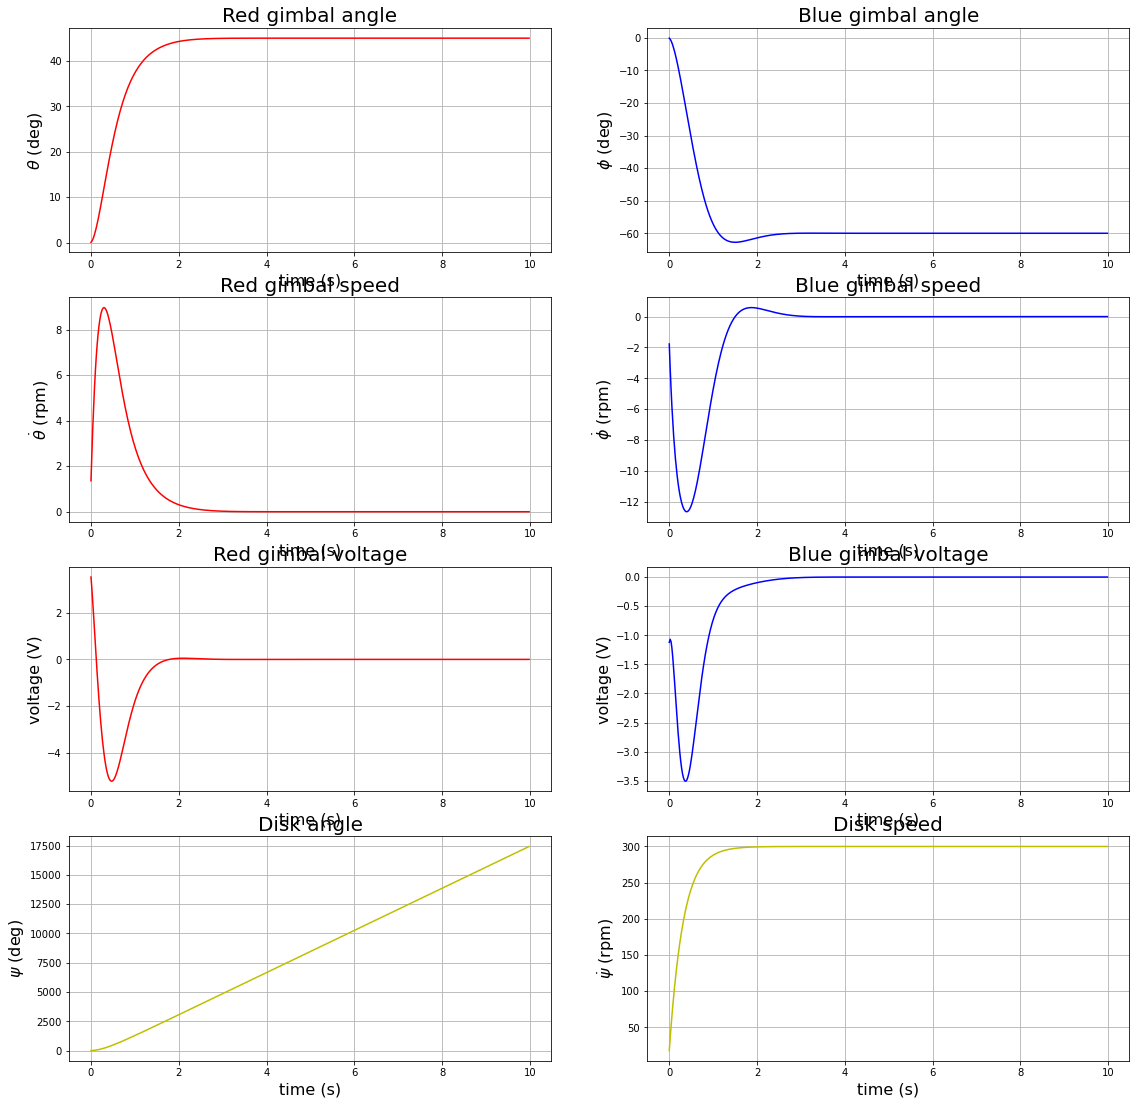

In [8]:
f, axs = plt.subplots(4,2,figsize=(19,19))

plt.subplot(4,2,1)
plt.title('Red gimbal angle',fontsize=20)
plt.xlabel('time (s)',fontsize=16)
plt.ylabel(r'$\theta$ (deg)',fontsize=16)
plt.grid()
plt.plot(time,x_arr[:,0]/np.pi*180,'r-')

plt.subplot(4,2,2)
plt.title('Blue gimbal angle',fontsize=20)
plt.xlabel('time (s)',fontsize=16)
plt.ylabel(r'$\phi$ (deg)',fontsize=16)
plt.grid()
plt.plot(time,x_arr[:,2]/np.pi*180,'b-')

plt.subplot(4,2,3)
plt.title('Red gimbal speed',fontsize=20)
plt.xlabel('time (s)',fontsize=16)
plt.ylabel(r'$\dot \theta$ (rpm)',fontsize=16)
plt.grid()
plt.plot(time,x_arr[:,1]/2/np.pi*60,'r-')

plt.subplot(4,2,4)
plt.title('Blue gimbal speed',fontsize=20)
plt.xlabel('time (s)',fontsize=16)
plt.ylabel(r'$\dot \phi$ (rpm)',fontsize=16)
plt.grid()
plt.plot(time,x_arr[:,3]/2/np.pi*60,'b-')

plt.subplot(4,2,5)
plt.title('Red gimbal voltage',fontsize=20)
plt.xlabel('time (s)',fontsize=16)
plt.ylabel('voltage (V)',fontsize=16)
plt.grid()
plt.plot(time,u1_arr,'r-')

plt.subplot(4,2,6)
plt.title('Blue gimbal voltage',fontsize=20)
plt.xlabel('time (s)',fontsize=16)
plt.ylabel('voltage (V)',fontsize=16)
plt.grid()
plt.plot(time,u2_arr,'b-')

plt.subplot(4,2,7)
plt.title('Disk angle',fontsize=20)
plt.xlabel('time (s)',fontsize=16)
plt.ylabel(r'$\psi$ (deg)',fontsize=16)
plt.grid()
plt.plot(time,x_arr[:,4]/np.pi*180,'y-')

plt.subplot(4,2,8)
plt.title('Disk speed',fontsize=20)
plt.xlabel('time (s)',fontsize=16)
plt.ylabel(r'$\dot \psi$ (rpm)',fontsize=16)
plt.grid()
plt.plot(time,x_arr[:,5]/2/np.pi*60,'y-')

plt.show()

## Simulation, 6 states, RL controller

In [9]:
# Initial conditions: [theta, theta dot, phi, phi dot, psi, psi dot]
x = [0, 0, 0, 0, 0, w]

# Time step in sec and time vector
dt = 0.05
time = np.arange(0, 10, dt)

# Actor
agent = torch.load('../training_spinuplib/td3_nh_b2/pyt_save/model.pt')

# Store
x_arr = np.empty([len(time), len(x)])
u1_arr = np.empty([len(time), 1])
u2_arr = np.empty([len(time), 1])

# Simulation
for i in range(len(time)):
    T3 = 0.1*(w-x[5]) # to control disk with P controller as done on machine
    obs = [np.cos(x[0]),np.sin(x[0]),x[1]/(max_speed),
           np.cos(x[2]),np.sin(x[2]),x[3]/(max_speed),
           45/180,-60/180,x[-1]/max_diskspeed]
    u1,u2 = agent.act(torch.as_tensor(obs, dtype=torch.float32))
    results = solve_ivp(dx_dt6, (0, dt), x, method='RK45', args=(KtotRed*10*u1,KtotBlue*10*u2,T3))
    x = [row[-1] for row in results.y] 
    u1_arr[i] = u1*10
    u2_arr[i] = u2*10
    x_arr[i] = x

## Plot

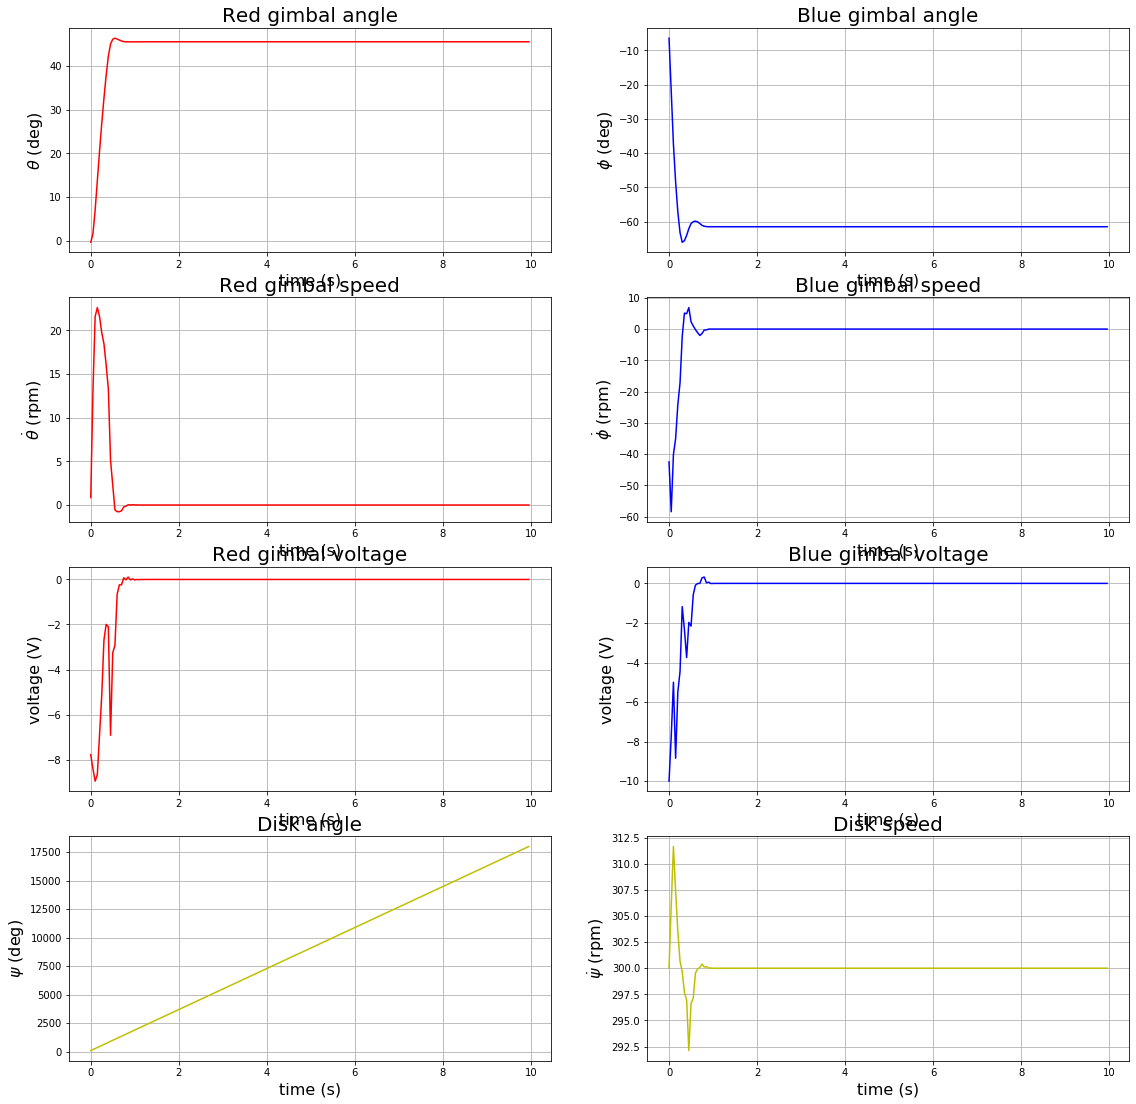

In [10]:
f, axs = plt.subplots(4,2,figsize=(19,19))

plt.subplot(4,2,1)
plt.title('Red gimbal angle',fontsize=20)
plt.xlabel('time (s)',fontsize=16)
plt.ylabel(r'$\theta$ (deg)',fontsize=16)
plt.grid()
plt.plot(time,x_arr[:,0]/np.pi*180,'r-')

plt.subplot(4,2,2)
plt.title('Blue gimbal angle',fontsize=20)
plt.xlabel('time (s)',fontsize=16)
plt.ylabel(r'$\phi$ (deg)',fontsize=16)
plt.grid()
plt.plot(time,x_arr[:,2]/np.pi*180,'b-')

plt.subplot(4,2,3)
plt.title('Red gimbal speed',fontsize=20)
plt.xlabel('time (s)',fontsize=16)
plt.ylabel(r'$\dot \theta$ (rpm)',fontsize=16)
plt.grid()
plt.plot(time,x_arr[:,1]/2/np.pi*60,'r-')

plt.subplot(4,2,4)
plt.title('Blue gimbal speed',fontsize=20)
plt.xlabel('time (s)',fontsize=16)
plt.ylabel(r'$\dot \phi$ (rpm)',fontsize=16)
plt.grid()
plt.plot(time,x_arr[:,3]/2/np.pi*60,'b-')

plt.subplot(4,2,5)
plt.title('Red gimbal voltage',fontsize=20)
plt.xlabel('time (s)',fontsize=16)
plt.ylabel('voltage (V)',fontsize=16)
plt.grid()
plt.plot(time,u1_arr,'r-')

plt.subplot(4,2,6)
plt.title('Blue gimbal voltage',fontsize=20)
plt.xlabel('time (s)',fontsize=16)
plt.ylabel('voltage (V)',fontsize=16)
plt.grid()
plt.plot(time,u2_arr,'b-')

plt.subplot(4,2,7)
plt.title('Disk angle',fontsize=20)
plt.xlabel('time (s)',fontsize=16)
plt.ylabel(r'$\psi$ (deg)',fontsize=16)
plt.grid()
plt.plot(time,x_arr[:,4]/np.pi*180,'y-')

plt.subplot(4,2,8)
plt.title('Disk speed',fontsize=20)
plt.xlabel('time (s)',fontsize=16)
plt.ylabel(r'$\dot \psi$ (rpm)',fontsize=16)
plt.grid()
plt.plot(time,x_arr[:,5]/2/np.pi*60,'y-')

plt.show()

## Simplified non-linear system equations (4 states)

In [11]:
def dx_dt4(t, x, T1, T2):
    dx_dt = [0, 0, 0, 0]
    dx_dt[0] = x[1]
    dx_dt[1] = (T1-0.000*np.sign(x[1]) - 0*x[1] +J1*np.sin(2*x[2])*x[1]*x[3]-Jdx3*np.cos(x[2])*x[3]*w)/(J2 + J1*np.power(np.sin(x[2]),2))
    dx_dt[2] = x[3]
    dx_dt[3] = (T2-0.000*np.sign(x[3]) - 0*x[3] - J1*np.cos(x[2])*np.sin(x[2])*np.power(x[1],2)+Jdx3*np.cos(x[2])*x[1]*w)/J3
    return dx_dt

## Simulation

In [12]:
# Initial conditions: [theta, theta dot, phi, phi dot, psi, psi dot]
x = [0, 0, 0, 0]

# Time step in sec and time vector
dt = 0.05
time = np.arange(0, 10, dt)

# Actor
agent = torch.load('../training_spinuplib/td3_nh_b2/pyt_save/model.pt')

# Store
x_arr = np.empty([len(time), len(x)])
u1_arr = np.empty([len(time), 1])
u2_arr = np.empty([len(time), 1])

# Simulation
for i in range(len(time)):
    obs = [np.cos(x[0]),np.sin(x[0]),x[1]/(max_speed),
           np.cos(x[2]),np.sin(x[2]),x[3]/(max_speed),
           45/180,-60/180,w/max_diskspeed]
    u1,u2 = agent.act(torch.as_tensor(obs, dtype=torch.float32))
    results = solve_ivp(dx_dt4, (0, dt), x, method='RK45', args=(KtotRed*10*u1,KtotBlue*10*u2))
    x = [row[-1] for row in results.y] 
    u1_arr[i] = u1*10
    u2_arr[i] = u2*10
    x_arr[i] = x

## Plot

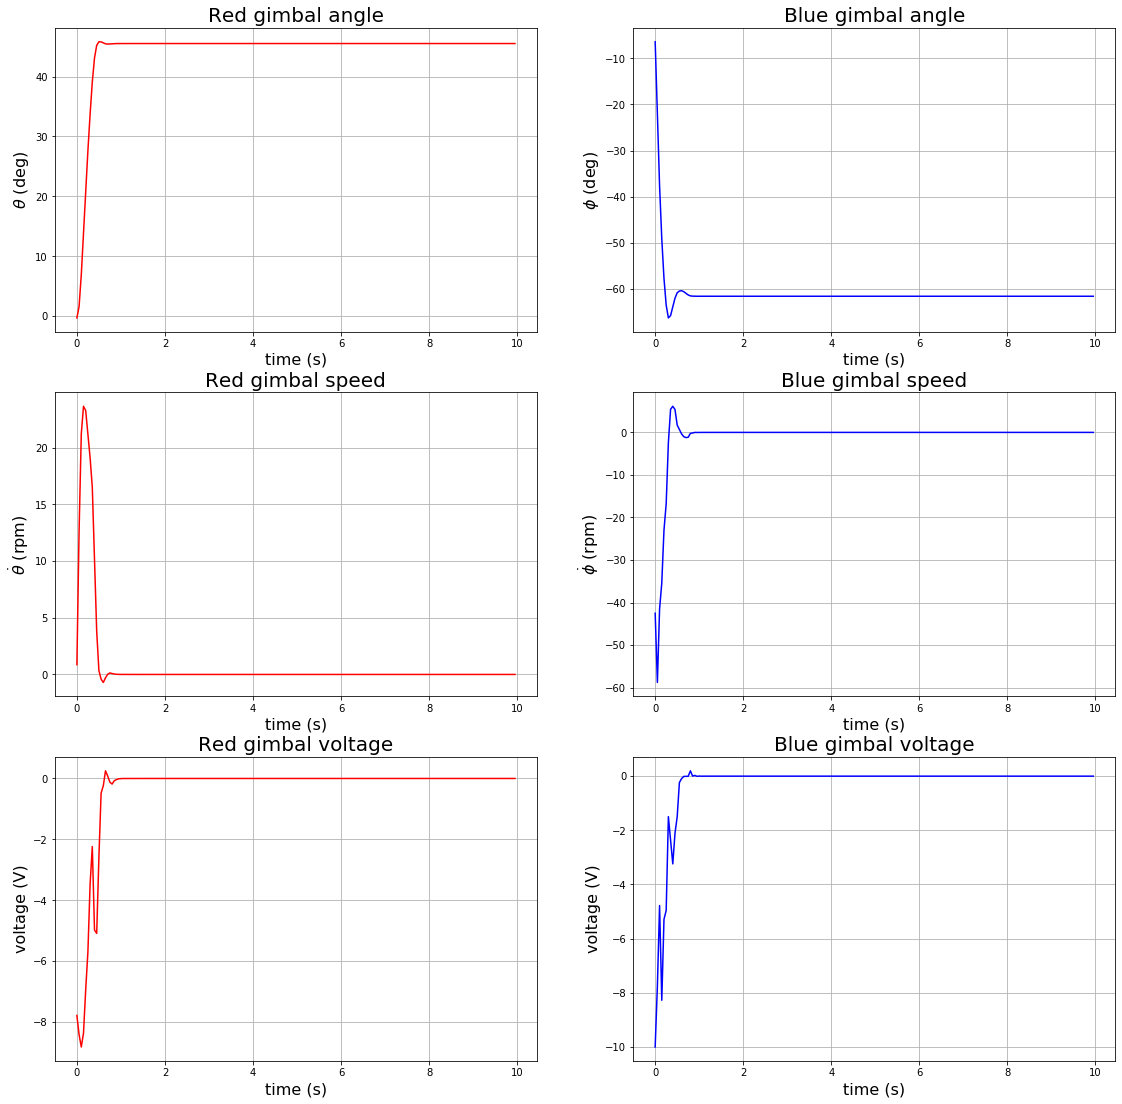

In [13]:
f, axs = plt.subplots(4,2,figsize=(19,19))

plt.subplot(3,2,1)
plt.title('Red gimbal angle',fontsize=20)
plt.xlabel('time (s)',fontsize=16)
plt.ylabel(r'$\theta$ (deg)',fontsize=16)
plt.grid()
plt.plot(time,x_arr[:,0]/np.pi*180,'r-')

plt.subplot(3,2,2)
plt.title('Blue gimbal angle',fontsize=20)
plt.xlabel('time (s)',fontsize=16)
plt.ylabel(r'$\phi$ (deg)',fontsize=16)
plt.grid()
plt.plot(time,x_arr[:,2]/np.pi*180,'b-')

plt.subplot(3,2,3)
plt.title('Red gimbal speed',fontsize=20)
plt.xlabel('time (s)',fontsize=16)
plt.ylabel(r'$\dot \theta$ (rpm)',fontsize=16)
plt.grid()
plt.plot(time,x_arr[:,1]/2/np.pi*60,'r-')

plt.subplot(3,2,4)
plt.title('Blue gimbal speed',fontsize=20)
plt.xlabel('time (s)',fontsize=16)
plt.ylabel(r'$\dot \phi$ (rpm)',fontsize=16)
plt.grid()
plt.plot(time,x_arr[:,3]/2/np.pi*60,'b-')

plt.subplot(3,2,5)
plt.title('Red gimbal voltage',fontsize=20)
plt.xlabel('time (s)',fontsize=16)
plt.ylabel('voltage (V)',fontsize=16)
plt.grid()
plt.plot(time,u1_arr,'r-')

plt.subplot(3,2,6)
plt.title('Blue gimbal voltage',fontsize=20)
plt.xlabel('time (s)',fontsize=16)
plt.ylabel('voltage (V)',fontsize=16)
plt.grid()
plt.plot(time,u2_arr,'b-')

plt.show()

In [5]:
Jrx1 = 0.0179
Jbx1 = 0.0019
Jbx2 = 0.0008
Jbx3 = 0.0012
Jdx1 = 0.0028
Jdx2 = 0.0056
Jdx3 = 0.0056

# Combined inertias to simplify equations, from SP report page 22, state space equations
J1 = Jbx1 - Jbx3 + Jdx1 - Jdx3
J2 = Jbx1 + Jdx1 + Jrx1
J3 = Jbx2 + Jdx1

J1

-0.0021